
# Potassium Sulfate, ³³S (I=3/2)

³³S (I=3/2) quadrupolar spectrum simulation.


> This notebook contains code adapted from the mrsimulator examples repository (https://github.com/mrsimulator/mrsimulator).
> See LICENSE-THIRD-PARTY.md for the BSD 3-Clause license details.


The following example is the $^{33}\text{S}$ NMR spectrum simulation of
potassium sulfate ($\text{K}_2\text{SO}_4$). The quadrupole tensor parameters
for $^{33}\text{S}$ is obtained from Moudrakovski `et al.` [1](#f3)



In [1]:
import matplotlib.pyplot as plt

from mrsimulator import Simulator, SpinSystem, Site
from mrsimulator import signal_processor as sp
from mrsimulator.method.lib import BlochDecayCTSpectrum
from mrsimulator.spin_system.tensors import SymmetricTensor
from mrsimulator.method import SpectralDimension

Create the spin system manually using parameters from the above paper.



In [2]:
site = Site(
    name="33S",
    isotope="33S",
    isotropic_chemical_shift=335.7,  # in ppm
    quadrupolar=SymmetricTensor(Cq=0.959e6, eta=0.42),  # Cq is in Hz
)
spin_system = SpinSystem(sites=[site])

And now the spin system from the magres file.

In [3]:
from ase.io import read
from soprano.selection import AtomSelection
from soprano.properties.nmr import get_spin_system

atoms = read("../example_data/K2SO4/nmr/K2SO4_nmr.magres")

# Get subset using cif labels present
sel = AtomSelection.from_selection_string(atoms, "S2")
atoms = sel.subset(atoms)

# Just get the unique site
atoms = AtomSelection.unique(atoms).subset(atoms)

# Extract the spin system in MRSimulator format
# (Note I chose the reference here to get a chemical shift that matches that above...)
magres_spin_system = get_spin_system(atoms, references={"S": 527.27}).to_mrsimulator()

Let's examine the extracted spin system:

In [4]:
magres_spin_system

{'sites': [{'isotope': '33S',
   'label': 'S2',
   'isotropic_chemical_shift': 335.6990501301363,
   'shielding_symmetric': {'zeta': -17.45164198359879,
    'eta': 0.39057823553262794,
    'alpha': 0.0,
    'beta': 1.5042266409084324,
    'gamma': 0.0},
   'quadrupolar': {'Cq': 889194.802477634,
    'eta': 0.6318017377906123,
    'alpha': 6.283185307179572,
    'beta': 1.4896261536785769,
    'gamma': 1.5707963267949259}}],
 'couplings': []}

It looks very similar to the one we created manually. The main difference is that this spin system also has orientation information (Euler angles) for the MS and EFG tensors.

Create a central transition selective Bloch decay spectrum method.



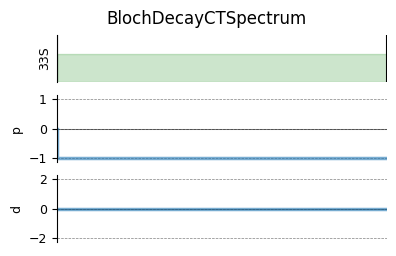

In [5]:
method = BlochDecayCTSpectrum(
    channels=["33S"],
    magnetic_flux_density=21.14,  # in T
    rotor_frequency=14000,  # in Hz
    spectral_dimensions=[
        SpectralDimension(
            count=2048,
            spectral_width=5000,  # in Hz
            reference_offset=22500,  # in Hz
            label=r"$^{33}$S resonances",
        )
    ],
)

# A graphical representation of the method object.
plt.figure(figsize=(4, 2.5))
method.plot()
plt.show()

Create the Simulator object and add method and spin system objects.



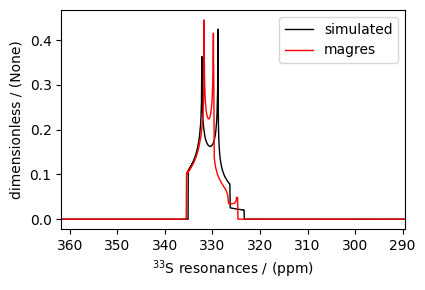

In [6]:
sim = Simulator(spin_systems=[spin_system], methods=[method])
sim.run()

magres_sim = Simulator(spin_systems=[magres_spin_system], methods=[method])
magres_sim.run()

# The plot of the simulation before signal processing.
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(sim.methods[0].simulation.real, color="black", linewidth=1, label="simulated")
ax.plot(magres_sim.methods[0].simulation.real, color="red", linewidth=1, label="magres")
ax.invert_xaxis()
ax.legend()
plt.tight_layout()
plt.show()

Add post-simulation signal processing.



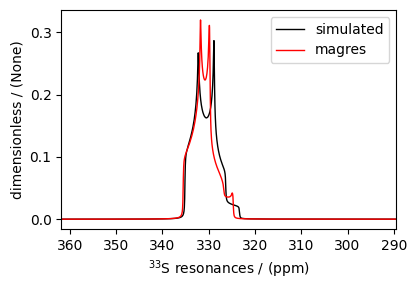

In [7]:
processor = sp.SignalProcessor(
    operations=[sp.IFFT(), sp.apodization.Exponential(FWHM="10 Hz"), sp.FFT()]
)

processed_dataset = processor.apply_operations(dataset=sim.methods[0].simulation)
magres_processed_dataset = processor.apply_operations(dataset=magres_sim.methods[0].simulation)

# The plot of the simulation after signal processing.
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(processed_dataset.real, color="black", linewidth=1, label="simulated")
ax.plot(magres_processed_dataset.real, color="red", linewidth=1, label="magres")
ax.invert_xaxis()
ax.legend()
plt.tight_layout()
plt.show()

1. <a name="f3"></a> Moudrakovski, I., Lang, S., Patchkovskii, S., and Ripmeester, J. High field
      $^{33}\text{S}$ solid state NMR and first-principles calculations in
      potassium sulfates. J. Phys. Chem. A, 2010, **114**, *1*, 309–316.
      [DOI: 10.1021/jp908206c](https://doi.org/10.1021/jp908206c)

